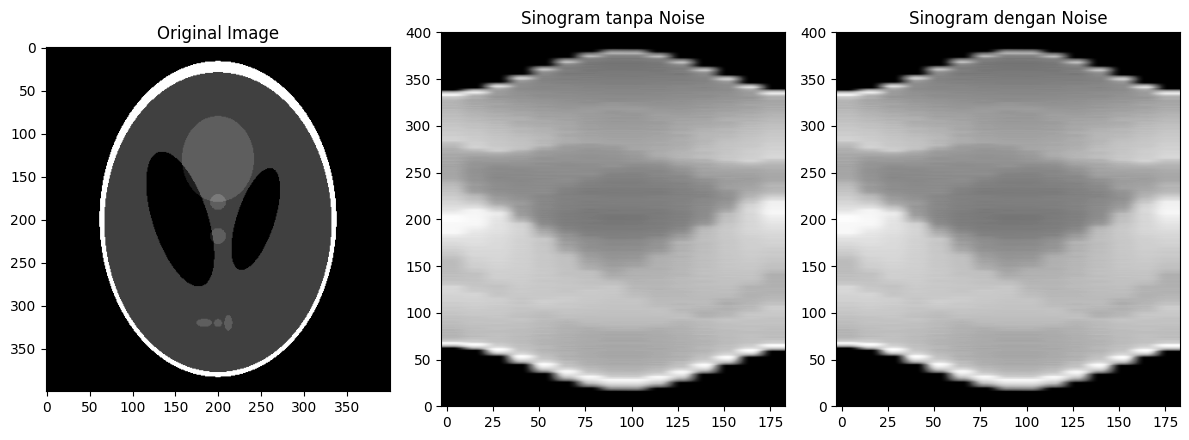

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data,color
from skimage.transform import radon, rescale

#Generate phantom image
image = data.shepp_logan_phantom()

#Generate sinogram without noise
theta = np.linspace(0., 180., 15, endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / 30, 0.5 / sinogram.shape[0]

#Add noise to sinogram
noise_level = 0.5  # You can adjust this parameter to control the amount of noise
noisy_sinogram = sinogram + noise_level

#Display the original and noisy sinogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))

ax1.set_title("Original Image")
ax1.imshow(image, cmap=plt.cm.Greys_r)

ax2.set_title("Sinogram tanpa Noise")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

ax3.set_title("Sinogram dengan Noise")
ax3.imshow(noisy_sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()


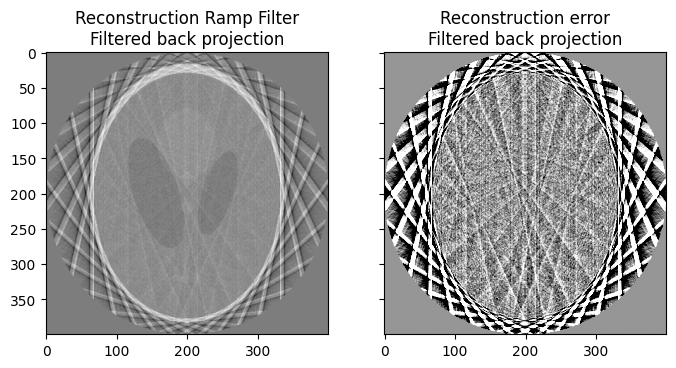

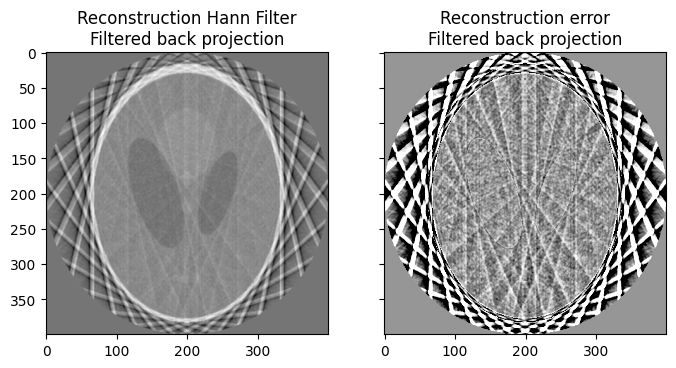

In [ ]:
from skimage.transform import iradon

reconstruction_fbp = iradon(noisy_sinogram, theta=theta, filter_name='ramp')
reconstruction_fbp2 = iradon(noisy_sinogram, theta=theta, filter_name='hann')
error = reconstruction_fbp - image
error2 = reconstruction_fbp2 - image
#print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction Ramp Filter\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax3.set_title("Reconstruction Hann Filter\nFiltered back projection")
ax3.imshow(reconstruction_fbp2, cmap=plt.cm.Greys_r)
ax4.set_title("Reconstruction error\nFiltered back projection")
ax4.imshow(reconstruction_fbp2 - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix
from skimage.transform import radon, rescale, resize

target = image
target = resize(target, (32, 32))
#Construct phantom. You can modify the resolution parameter N.
N = 32

#Choose measurement angles (given in degrees, not radians).
Nang = 15 # Number of angle
angle0 = -90
measang = angle0 + np.arange(Nang) / Nang * 180

#Initialize measurement matrix of size (M*P) x N^2, where M is the number of
#X-ray directions and P is the number of pixels that skimage's radon
#function gives.
P = len(radon(target, theta=[0]))
M = len(measang)
A = lil_matrix((M * P, N ** 2))

#Construct measurement matrix column by column. The trick is to construct
#targets with elements all 0 except for one element that equals 1.
for mmm in range(M):
    for iii in range(N ** 2):
        tmpvec = np.zeros(N ** 2)
        tmpvec[iii] = 1
        A[mmm * P : (mmm + 1) * P, iii] = radon(tmpvec.reshape(N, N), theta=[measang[mmm]])

       # if iii % 100 == 0:
        #    print(mmm, M, iii, N ** 2)

/usr/local/lib/python3.10/dist-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


In [ ]:
print("Shape of A:", A.shape)
print("Shape of Image:",target.shape)
A = A.toarray()

Shape of A: (480, 1024)
Shape of Image: (32, 32)


Alpha = 0.01


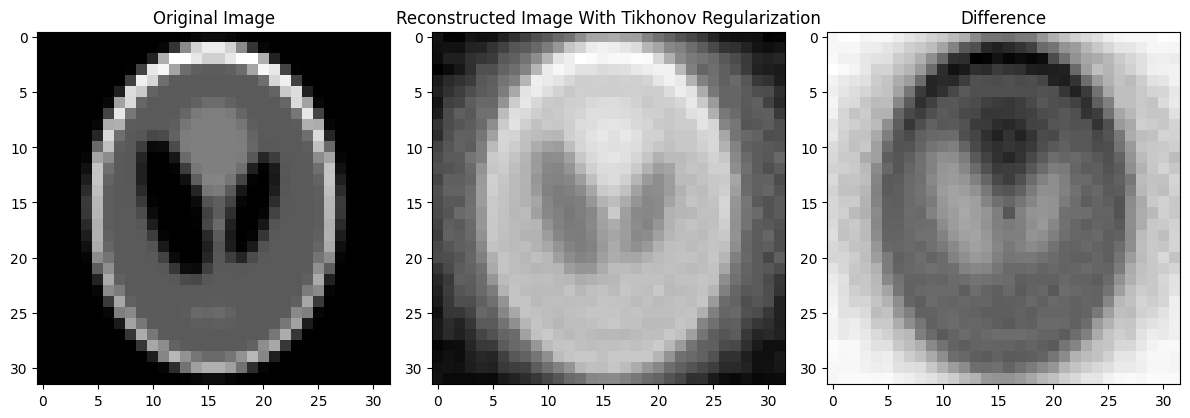

Alpha = 10


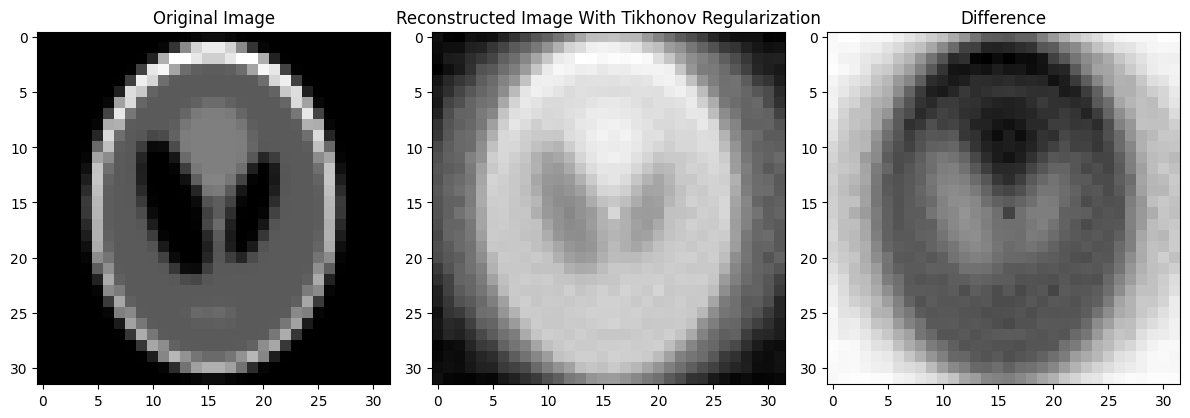

Alpha = 100


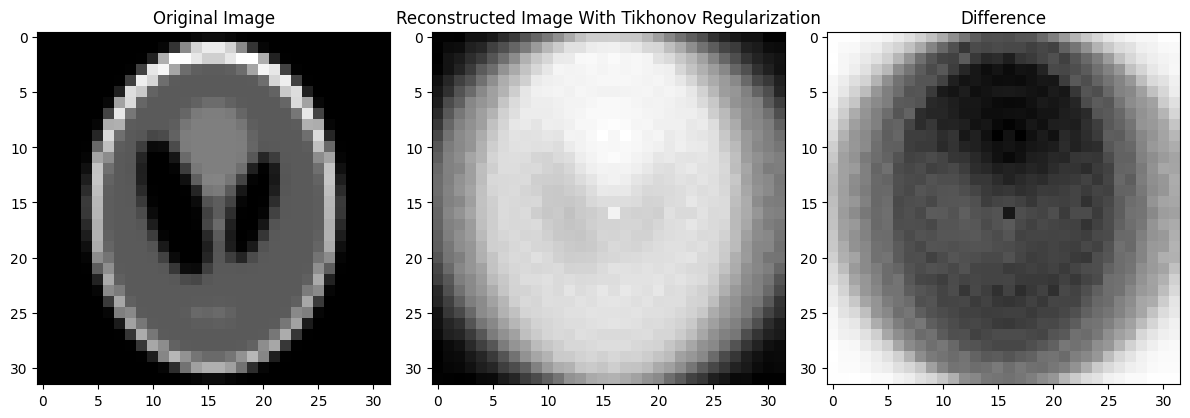

In [ ]:
#SVD
U, s, V = np.linalg.svd(A, full_matrices=False)

#Determine the number of singular values to use
k = 480

#Create S matrix based on singular value
S = np.zeros((k, k))
np.fill_diagonal(S, s[:k])

Uk = U[:,:k]
Vtk = V[:k,:]

#Calculate the projection of the target image
f = target.flatten()
b = A.dot(f)

alphas = [0.01,10,100]

#Tikhonov Regularization method to reconstruct the image
results = []
for alpha in alphas:
  # Gunakan nilai alpha yang lebih besar
  Tikh = np.diag(s[:k]**2 / (s[:k]**2 + alpha))
  Tikh_VDU = np.dot(np.dot(Vtk.T, Tikh), Uk.T)
  f_recon = Tikh_VDU.dot(b)
  results.append(f_recon)
  print(f"Alpha = {alpha}")

  #Convert the reconstructed image vector into an image matrix
  recon_img = np.reshape(results[-1], (N, N))

  #Display the reconstructed image
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))

  ax1.set_title("Original Image")
  ax1.imshow(target, cmap=plt.cm.Greys_r)

  ax2.set_title("Reconstructed Image With Tikhonov Regularization")
  ax2.imshow(recon_img, cmap=plt.cm.Greys_r)

  ax3.set_title("Difference")
  ax3.imshow(target - recon_img, cmap=plt.cm.Greys_r)

  fig.tight_layout()
  plt.show()

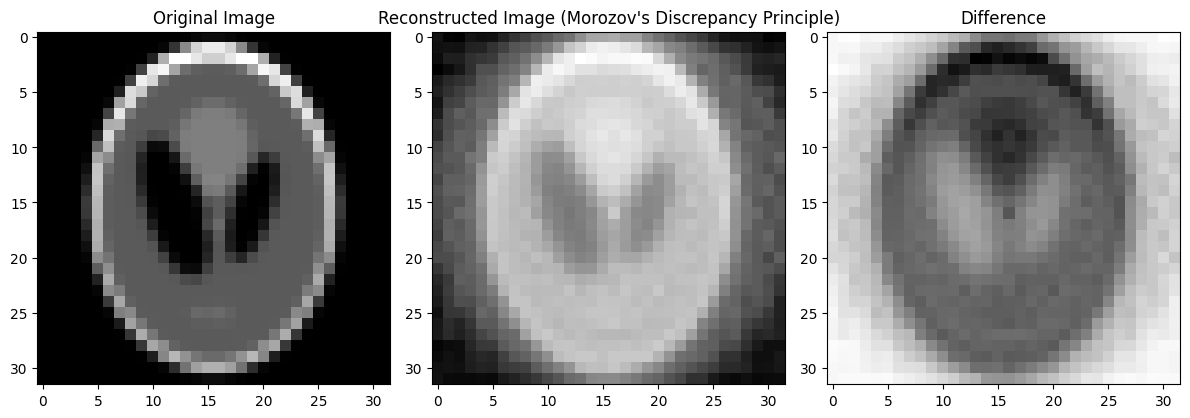

In [ ]:
from scipy.linalg import lstsq

# Morozov's Discrepancy Principle
mpilkku = U.T @ b
minimum = np.linalg.norm(mpilkku[k+1:])
maximum = np.linalg.norm(mpilkku)
delta = np.sqrt(len(b)) * noise_level

if minimum > delta or delta > maximum:
    raise ValueError("Morozov condition is not satisfied; cannot continue computation")

alphavec = np.arange(0.00001, 2, 0.005)
objfun = np.zeros(len(alphavec))
dvec = np.zeros(k)
for iii, alpha in enumerate(alphavec):
    dvec[:k] = (alpha / (alpha + s[:k] @ s[:k]) * mpilkku[:k]).reshape((-1,))
    dvec[k:] = mpilkku[k:].reshape((-1,))
    objfun[iii] = np.dot(dvec, dvec) - delta**2

alpha_mor = alphavec[np.argmax(objfun > 0)]

# Reconstruct from noisy data using Tikhonov regularization and alpha as regularization parameter
Tikh = np.diag(s[:k]**2 / (s[:k]**2 + alpha_mor))
Tikh_VDU = np.dot(np.dot(Vtk.T, Tikh), Uk.T)
f_recon_morozov = Tikh_VDU.dot(b)

# Ubah vektor citra yang direkonstruksi menjadi matriks citra
recon_img_morozov = np.reshape(f_recon_morozov, (N, N))

# Tampilkan citra yang telah direkonstruksi dengan Morozov's Discrepancy Principle
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))

ax1.set_title("Original Image")
ax1.imshow(target, cmap=plt.cm.Greys_r)

ax2.set_title("Reconstructed Image (Morozov's Discrepancy Principle)")
ax2.imshow(recon_img_morozov, cmap=plt.cm.Greys_r)

ax3.set_title("Difference")
ax3.imshow(target - recon_img_morozov, cmap=plt.cm.Greys_r)

fig.tight_layout()
plt.show()


In [ ]:
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt
import numpy as np

def PSNR(target, recon_img):
    mse = np.mean((target - recon_img) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

Errorfiltered1 = np.linalg.norm(error)/np.linalg.norm(image)
psnr = PSNR(image, reconstruction_fbp)
ssim_val = ssim(image, reconstruction_fbp, data_range=image.max() - image.min())

print("Error Relatif: ", Errorfiltered1*100,'%')
print("PSNR: ", psnr)
print("SSIM: ", ssim_val)

Error Relatif:  94.54083278327509 %
PSNR:  60.772388012606946
SSIM:  0.29311804448394974


In [ ]:
Errorfiltered2 = np.linalg.norm(error2)/np.linalg.norm(image)
psnr = PSNR(image, reconstruction_fbp2)
ssim_val = ssim(image, reconstruction_fbp2, data_range=image.max() - image.min())

print("Error Relatif: ", Errorfiltered2*100,'%')
print("PSNR: ", psnr)
print("SSIM: ", ssim_val)

Error Relatif:  79.20761289300656 %
PSNR:  62.30943798370415
SSIM:  0.3932244693490435


In [ ]:
for alpha, result in zip(alphas, results):
    recon_img = np.reshape(result, (N, N))

    # Menghitung metrik kesalahan
    psnr = PSNR(target, recon_img)
    error = np.linalg.norm(target - recon_img) / np.linalg.norm(target)
    ssim_val = ssim(target, recon_img, data_range=target.max() - target.min())

    print(f"Alpha = {alpha}")
    print("Error Relatif: ", error * 100, '%')
    print("PSNR: ", psnr)
    print("SSIM: ", ssim_val)

Alpha = 0.01
Error Relatif:  1484.7593411076434 %
PSNR:  39.04534188809716
SSIM:  0.027132272583254985
Alpha = 10
Error Relatif:  1435.4406635467508 %
PSNR:  39.33875831541452
SSIM:  0.030251640270373782
Alpha = 100
Error Relatif:  1155.662011312854 %
PSNR:  41.22184646359682
SSIM:  0.04233204301601339


In [ ]:
psnr = PSNR(target, recon_img_morozov)
error = np.linalg.norm(target - recon_img_morozov) / np.linalg.norm(target)
ssim_val = ssim(target, recon_img_morozov, data_range=target.max() - target.min())

print(alpha_mor)
print("Error Relatif: ", error * 100, '%')
print("PSNR: ", psnr)
print("SSIM: ", ssim_val)

1e-05
Error Relatif:  1484.8160050910408 %
PSNR:  39.04501040830701
SSIM:  0.02712871132986066


From the results obtained, it can be concluded that filtered backprojection with Hann Filter gives better results compared to Ramp Filter, indicated by lower Relative Error (79.20% vs. 94.54%), higher PSNR (62.31 vs. 60.77), and higher SSIM (0.39 vs. 0.29) Tikhonov regularization and Morozov discrepancy principle have very high Relative Error (>1000%) and low PSNR values when compared to Filtered backprojection method. This suggests that these two methods may not be effective for this data.

For Tikhonov regularization, the α value does not seem to have a significant effect on the Relative Error, PSNR, and SSIM. However, increasing α from 0.01 to 100 results in a decrease in Relative Error and an increase in PSNR and SSIM, suggesting that increasing α may slightly improve performance. The use of the α value from the Morozov discrepancy principle also has results that are not much different from the results with a predetermined α value.

The image results of the reconstruction also show that the reconstruction results with the filtered backprojection method have the best results and look very similar to the original image while for the Tikhonov regularization method it can be seen that the results obtained are quite similar when the α value used is quite small, this is inversely proportional when we look at the relative error, namely the greater the α value, the smaller the error will be. The use of the α value from the Morozov discrepancy principle has the most similar results to the original image when compared to the use of the α value determined from the beginning, this is because the α obtained from the Morozov discrepancy principle has a very small value.